In [1]:
import pandas as pd
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
import matplotlib.dates
from matplotlib.dates import date2num
import seaborn as sns 
import warnings
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
%matplotlib inline
warnings.filterwarnings("ignore")

# 1. Load And Clean Data

In [2]:
Aurubis = pd.read_csv('Arubis.csv')
Aurubis = Aurubis.rename(columns={"Mchine Sequence": "Machine Sequence"})
Aurubis.head()

,Order Id,Coil Id,Machine Sequence,Machine Id,Metal Density,Alloy Type,Start Gauge,Start Width,Start Lbs,Finish lbs,Actual Yield,Standard Yield,Start date,Finish date
0,1154,693873,30,44,0.308,2608.0,0.2500,38.41,20989,20209,0.962838,0.995705,2019/3/27,2019/3/27
1,1154,693873,40,133,0.308,2608.0,0.0905,38.41,20209,20209,1.000000,0.994892,2019/3/27,2019/3/28
2,1154,693873,50,68,0.308,2608.0,0.0905,38.41,20209,20209,1.000000,0.838448,2019/3/28,2019/3/28
3,1154,693874,30,44,0.308,2608.0,0.2500,38.43,19534,19590,1.002867,0.995705,2019/3/27,2019/3/27
4,1154,693874,40,133,0.308,2608.0,0.0905,38.43,19590,19590,1.000000,0.994892,2019/3/27,2019/3/28


In [3]:
Aurubis = Aurubis.drop(['Finish lbs', 'Finish date', 'Order Id', 'Coil Id','Machine Sequence', 'Machine Id', 'Alloy Type'], axis=1) # Drop useless columns
Aurubis = Aurubis[Aurubis['Actual Yield'] <= 1] # Limit the actual yield to be less than 1

In [4]:
Aurubis.describe()

,Metal Density,Start Gauge,Start Width,Start Lbs,Actual Yield,Standard Yield
count,108235.000000,108235.000000,108235.000000,108235.000000,108235.000000,108235.000000
mean,0.317302,0.066604,27.449758,13789.290267,0.938528,0.942115
std,0.006578,0.096071,10.728527,6946.955808,0.182471,0.088655
min,0.000000,0.000000,0.935000,10.000000,0.000900,0.105152
25%,0.308000,0.012400,25.000000,7841.000000,0.960662,0.920011
50%,0.321000,0.023000,27.010000,14093.000000,1.000000,0.980084
75%,0.322000,0.064300,38.150000,19307.000000,1.000000,0.998242
max,0.323000,0.650000,51.650000,32126.000000,1.000000,2.569125


In [5]:
Aurubis.isnull().any() 

Metal Density     False
Start Gauge       False
Start Width       False
Start Lbs         False
Actual Yield      False
Standard Yield    False
Start date        False
dtype: bool

In [6]:
Aurubis = Aurubis.dropna() # Remove rows containing null values

# 2. Feature Engineering

In [7]:
Aurubis['Start date'] = pd.to_datetime(Aurubis['Start date'], 
 format = '%Y-%m-%d', 
 errors = 'coerce')

In [8]:
Aurubis.head()

,Metal Density,Start Gauge,Start Width,Start Lbs,Actual Yield,Standard Yield,Start date
0,0.308,0.2500,38.41,20989,0.962838,0.995705,2019-03-27
1,0.308,0.0905,38.41,20209,1.000000,0.994892,2019-03-27
2,0.308,0.0905,38.41,20209,1.000000,0.838448,2019-03-28
4,0.308,0.0905,38.43,19590,1.000000,0.994892,2019-03-27
5,0.308,0.0905,38.43,19590,1.000000,0.838448,2019-03-28


### Extract Useful Information From Date Variable

In [9]:
Aurubis['Start date_year'] = Aurubis['Start date'].dt.year
Aurubis['Start date_month'] = Aurubis['Start date'].dt.month
Aurubis['Start date_week'] = Aurubis['Start date'].dt.week
Aurubis['Start date_day'] = Aurubis['Start date'].dt.day
Aurubis['Start date_dayofweek'] = Aurubis['Start date'].dt.dayofweek
Aurubis['Weekend'] = Aurubis['Start date_dayofweek']>4

In [10]:
Aurubis.head()

,Metal Density,Start Gauge,Start Width,Start Lbs,Actual Yield,Standard Yield,Start date,Start date_year,Start date_month,Start date_week,Start date_day,Start date_dayofweek,Weekend
0,0.308,0.2500,38.41,20989,0.962838,0.995705,2019-03-27,2019,3,13,27,2,False
1,0.308,0.0905,38.41,20209,1.000000,0.994892,2019-03-27,2019,3,13,27,2,False
2,0.308,0.0905,38.41,20209,1.000000,0.838448,2019-03-28,2019,3,13,28,3,False
4,0.308,0.0905,38.43,19590,1.000000,0.994892,2019-03-27,2019,3,13,27,2,False
5,0.308,0.0905,38.43,19590,1.000000,0.838448,2019-03-28,2019,3,13,28,3,False


In [11]:
Aurubis.groupby('Start date_year').count()

,Metal Density,Start Gauge,Start Width,Start Lbs,Actual Yield,Standard Yield,Start date,Start date_month,Start date_week,Start date_day,Start date_dayofweek,Weekend
Start date_year,,,,,,,,,,,,
2017,2,2,2,2,2,2,2,2,2,2,2,2
2018,1023,1023,1023,1023,1023,1023,1023,1023,1023,1023,1023,1023
2019,97950,97950,97950,97950,97950,97950,97950,97950,97950,97950,97950,97950
2020,9260,9260,9260,9260,9260,9260,9260,9260,9260,9260,9260,9260


In [12]:
Aurubis.groupby('Start date_dayofweek').count()

,Metal Density,Start Gauge,Start Width,Start Lbs,Actual Yield,Standard Yield,Start date,Start date_year,Start date_month,Start date_week,Start date_day,Weekend
Start date_dayofweek,,,,,,,,,,,,
0,19193,19193,19193,19193,19193,19193,19193,19193,19193,19193,19193,19193
1,20435,20435,20435,20435,20435,20435,20435,20435,20435,20435,20435,20435
2,20849,20849,20849,20849,20849,20849,20849,20849,20849,20849,20849,20849
3,20780,20780,20780,20780,20780,20780,20780,20780,20780,20780,20780,20780
4,18696,18696,18696,18696,18696,18696,18696,18696,18696,18696,18696,18696
5,5625,5625,5625,5625,5625,5625,5625,5625,5625,5625,5625,5625
6,2657,2657,2657,2657,2657,2657,2657,2657,2657,2657,2657,2657


# 3. Build Models

In [13]:
Y = Aurubis['Actual Yield']
X = Aurubis.drop(['Actual Yield','Standard Yield','Start date'], axis=1)

In [14]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import scale 


### Train And Test Set

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=0)

### Random Forest And XGBoost

In [16]:
regressors = [
    RandomForestRegressor(max_depth=10, random_state=0, max_features = 10),
    XGBRegressor(max_depth=10, learning_rate=0.1, random_state=0)
    ]

In [17]:
MSE = []
for regressor in regressors:
    fit = regressor.fit(X_train, Y_train)
    pred = fit.predict(X_test)
    pred[pred > 1] = 1
    mse = mean_squared_error( Y_test,pred)
    MSE.append(mse)

In [18]:
MSE # The MSE of XGB is smaller than that of Random Forest

[0.03031491717522165, 0.029734164123278766]

### Ridge Regression

In [19]:
alphas = 10**np.linspace(10,-2,100)*0.5

In [20]:
ridge = Ridge(normalize = True)
coefs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X, Y)
    coefs.append(ridge.coef_)
    
np.shape(coefs)

(100, 10)

Text(0, 0.5, 'weights')

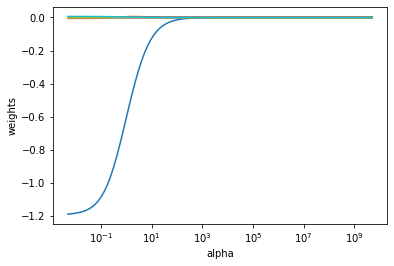

In [21]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [22]:
X_train, X_test , y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=1)

In [23]:
ridge2 = Ridge(alpha = 4, normalize = True)
ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred2 = ridge2.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred2))          # Calculate the test MSE

Metal Density          -2.663890e-01
Start Gauge             5.667810e-03
Start Width             1.422991e-04
Start Lbs               1.990359e-07
Start date_year         4.012771e-04
Start date_month       -4.625373e-05
Start date_week        -1.045566e-05
Start date_day          1.676478e-05
Start date_dayofweek    1.800927e-04
Weekend                 1.247354e-03
dtype: float64
0.033287424683203115


In [24]:
ridge3 = Ridge(alpha = 10**10, normalize = True)
ridge3.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred3 = ridge3.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge3.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred3))          # Calculate the test MSE

Metal Density          -1.486609e-10
Start Gauge             4.497201e-12
Start Width             8.916268e-14
Start Lbs               1.300191e-16
Start date_year         2.548167e-13
Start date_month       -2.890950e-14
Start date_week        -6.557733e-15
Start date_day          8.799319e-15
Start date_dayofweek    1.143872e-13
Weekend                 7.337228e-13
dtype: float64
0.03336109779682562


In [25]:
ridge2 = Ridge(alpha = 0, normalize = True)
ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred = ridge2.predict(X_test)            # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred))           # Calculate the test MSE

Metal Density          -1.208460e+00
Start Gauge            -9.220080e-03
Start Width             5.282189e-04
Start Lbs               2.782403e-07
Start date_year         2.049714e-03
Start date_month        8.964065e-03
Start date_week        -2.114052e-03
Start date_day          3.779787e-04
Start date_dayofweek    5.837946e-05
Weekend                 4.607088e-03
dtype: float64
0.0332210929503155


In [26]:
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

0.08148754173103201

In [27]:
ridge4 = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridge4.fit(X_train, y_train)
mean_squared_error(y_test, ridge4.predict(X_test))

0.03322373020047222

In [28]:
ridge4.fit(X, Y)
pd.Series(ridge4.coef_, index = X.columns)

Metal Density          -1.107731e+00
Start Gauge            -5.104001e-03
Start Width             6.107207e-04
Start Lbs               6.704882e-08
Start date_year         1.511579e-03
Start date_month       -1.751258e-04
Start date_week        -4.885643e-05
Start date_day          2.170140e-05
Start date_dayofweek   -2.650524e-04
Weekend                 5.718268e-03
dtype: float64

### Lasso Regression

Text(0, 0.5, 'weights')

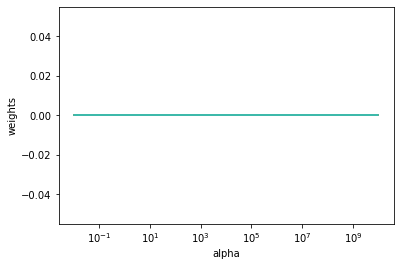

In [29]:
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [30]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
mean_squared_error(y_test, lasso.predict(X_test))

0.03322125504135588

# 4. Predict Yield Using The Ridge Regression

In [31]:
Aurubis['Predict Yield'] = ridge4.predict(X)
Aurubis['Predict Yield'][Aurubis['Predict Yield'] > 1] = 1

In [32]:
Aurubis[['Actual Yield', 'Standard Yield', 'Predict Yield']].head()

,Actual Yield,Standard Yield,Predict Yield
0,0.962838,0.995705,0.955793
1,1.000000,0.994892,0.956555
2,1.000000,0.838448,0.956311
4,1.000000,0.994892,0.956525
5,1.000000,0.838448,0.956282


### Evaluate The Model On The Whole Dataset

In [33]:
mean_squared_error(Aurubis['Predict Yield'],Aurubis['Actual Yield'])

0.0331452194129566

# 5. Data Visualization of Predicted Yield

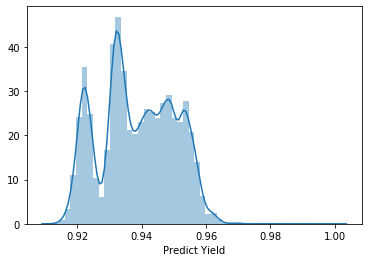

In [34]:
sns.distplot(Aurubis['Predict Yield'])

[Text(0, 0.5, 'Frequency')]

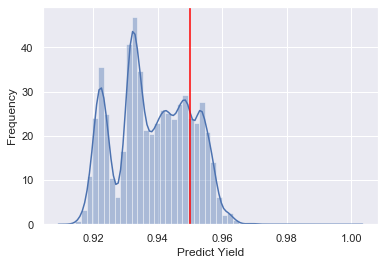

In [44]:
import seaborn as sns, numpy as np
import matplotlib.pyplot as plt
x = Aurubis['Predict Yield']
ax = sns.distplot(x)

x = ax.lines[0].get_xdata()
y = ax.lines[0].get_ydata()
plt.axvline(0.95, color='red')
ax.set(ylabel = "Frequency")